In [1]:
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np
import category_encoders as ce
%matplotlib inline
from IPython.display import display
from sklearn.model_selection import train_test_split

pd.options.display.max_columns = None
plt.style.use('bmh')

A  la suite de exécution de notre premier modèle, nous nous sommes aperçu qu'il n'était pas possible de travailler avec le fichier test.csv fournit par Kaggle. Le dataset n'est plus disponible à l'adresse suivante http://musicdatascience.com/emi-million-interview-dataset/. Comme nous avions déjà réalisé l'analyse de données et optimisé notre XGBoost, nous avons décidé de ne travailler que sur le dataset d'entraînement original. Les résultats obtenus sont cohérents avec ceux du classement Kaggle, même s'il nous est impossible de le vérifier. Par conséquent, le jeu de test original est ignoré et le jeu d'apprentissage original est splitté en train et test. Notre analyse préliminaire nous a montré que le jeu de test original était très semblable à notre jeu de test actuel (mêmes artistes, user et chansons), donc les calculs peuvent être considérés comme représentatifs.

# Chargement des datasets

In [2]:
train = pd.read_csv('./input/train.csv')

UserKey contient les headers de colonnes du fichier User avec la description du champ. Ces colonnes étant déjà présentes dans le csv user, ce fichier n'a qu'une visée descriptive. Nous le reformatons pour pouvoir afficher le contenu dans le notebook.

In [3]:
with open('./input/UserKey.csv', encoding='utf-8') as infile, open('./input/quotedUserKey.csv','w', encoding='utf-8') as outfile:
    reader = csv.reader(infile)
    writer = csv.writer(outfile)
    for line in reader:
        if len(line) > 2:
            temp_line = line[1]
            for i in range(2, len(line)):
                line[1] +=', '+line[i]
            line = line[:2]
        writer.writerow(line)                        

In [4]:
user_key = pd.read_csv('./input/quotedUserKey.csv', header=None)

In [5]:
#Affiche l'intégralité du champ
pd.set_option('display.max_colwidth', -1)
user_key

,0,1
0,RESPID,User id
1,GENDER,Male/Female
2,AGE,Age in years
3,WORKING,Working status
4,REGION,Region of the UK
5,MUSIC,Listening to music that you have chosen / bought (eg. playing CDs or listening to your iPod) -
6,LIST_OWN,Listening to music that may be on in the background (e.g. the radio or a streaming service like last.fm) -
7,LIST_BACK,Listening to music that may be on in the background (e.g. the radio or a streaming service like last.fm) -
8,Q1,"I enjoy actively searching for and discovering music that I have never heard before (Thinking now about music, to what extent would you agree or disagree with the following statements?)"
9,Q2,"I find it easy to find new music (Thinking now about music, to what extent would you agree or disagree with the following statements?)"


In [6]:
users = pd.read_csv('./input/users.csv')

le csv 'words' contient des caractères non compatibles avec le format utf-8, nous réenregistrons le fichier sous le bon format à l'aide d'un éditeur de texte.

In [7]:
words = pd.read_csv('./input/words.csv')

L'objectif de ce challenge est de prédire la valeur de la variable "Rating" sur le jeu de test. Cette variable a une valeur entière comprise entre X-100, comme il s'agit d'une notation, nous pouvons dire que c'est une variable continue et donc quil s'agit d'un problème de régression. De plus la métrique  d'évaluation est RMSE (Root Mean Squared Error) ce qui est une métrique de régression. L'objectif est d'obtenir un csv conenant les prédictions des évaluations pour le jeu de test.

In [8]:
train.head(10)

,Artist,Track,User,Rating,Time
0,40,179,47994,9,17
1,9,23,8575,58,7
2,46,168,45475,13,16
3,11,153,39508,42,15
4,14,32,11565,54,19
5,31,79,27130,37,11
6,21,48,19623,69,21
7,2,174,47505,28,17
8,12,34,15290,12,8
9,28,73,24151,70,22


In [9]:
users.head(2)

,RESPID,GENDER,AGE,WORKING,REGION,MUSIC,LIST_OWN,LIST_BACK,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19
0,36927,Female,60.0,Other,South,Music is important to me but not necessarily more important,1 hour,NaN,49.0,50.0,49.0,50.0,32.0,33.0,32.0,0.0,74.0,50.0,50.0,71.0,52.0,71.0,9.0,7.0,72.0,49.0,26.0
1,3566,Female,36.0,Full-time housewife / househusband,South,Music is important to me but not necessarily more important,1 hour,1 hour,55.0,55.0,62.0,9.0,9.0,9.0,10.0,11.0,55.0,12.0,65.0,65.0,80.0,79.0,51.0,31.0,68.0,54.0,33.0


In [10]:
words.head(10)

,Artist,User,HEARD_OF,OWN_ARTIST_MUSIC,LIKE_ARTIST,Uninspired,Sophisticated,Aggressive,Edgy,Sociable,Laid back,Wholesome,Uplifting,Intriguing,Legendary,Free,Thoughtful,Outspoken,Serious,Good lyrics,Unattractive,Confident,Old,Youthful,Boring,Current,Colourful,Stylish,Cheap,Irrelevant,Heartfelt,Calm,Pioneer,Outgoing,Inspiring,Beautiful,Fun,Authentic,Credible,Way out,Cool,Catchy,Sensitive,Mainstream,Superficial,Annoying,Dark,Passionate,Not authentic,Good Lyrics,Background,Timeless,Depressing,Original,Talented,Worldly,Distinctive,Approachable,Genius,Trendsetter,Noisy,Upbeat,Relatable,Energetic,Exciting,Emotional,Nostalgic,None of these,Progressive,Sexy,Over,Rebellious,Fake,Cheesy,Popular,Superstar,Relaxed,Intrusive,Unoriginal,Dated,Iconic,Unapproachable,Classic,Playful,Arrogant,Warm,Soulful,Unnamed: 87
0,47,45969,Heard of,NaN,NaN,NaN,0.0,NaN,0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0,0.0,0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0,0,0,0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0,0.0,0,NaN,0,0,NaN,0,0,0.0,0,NaN,0.0,NaN,0,0.0,0.0,NaN,0,NaN,0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0,0.0,NaN
1,35,29118,Never heard of,NaN,NaN,0.0,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0,NaN,0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0,1,0,0,NaN,0,1.0,0.0,0.0,0.0,0.0,NaN,0,0.0,NaN,NaN,0,0.0,0,0,NaN,1,0,NaN,0,0.0,0.0,0.0,0,NaN,NaN,NaN,0,NaN,0,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0,NaN,NaN
2,14,31544,Heard of,NaN,NaN,0.0,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0,NaN,0,0.0,0.0,NaN,1.0,NaN,0.0,0.0,1,0,0,0,NaN,0,0.0,0.0,0.0,0.0,0.0,NaN,0,0.0,NaN,NaN,0,0.0,0,1,NaN,0,0,NaN,0,0.0,0.0,0.0,0,NaN,NaN,NaN,0,NaN,0,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0,NaN,NaN
3,23,18085,Never heard of,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,1.0,0,NaN,0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0,0,0,0,NaN,0,0.0,0.0,0.0,0.0,NaN,NaN,0,NaN,NaN,NaN,0,0.0,0,0,NaN,0,0,NaN,0,0.0,0.0,0.0,0,NaN,NaN,NaN,0,NaN,0,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0,NaN,NaN
4,23,18084,Never heard of,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0,NaN,0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0,0,0,0,NaN,0,0.0,0.0,0.0,0.0,NaN,NaN,0,NaN,NaN,NaN,0,0.0,0,0,NaN,0,0,NaN,0,0.0,0.0,0.0,0,NaN,NaN,NaN,1,NaN,0,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0,NaN,NaN
5,23,18082,Never heard of,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0,NaN,0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0,0,0,0,NaN,0,0.0,0.0,0.0,0.0,NaN,NaN,0,NaN,NaN,NaN,0,0.0,0,0,NaN,0,0,NaN,0,0.0,0.0,0.0,0,NaN,NaN,NaN,1,NaN,0,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0,NaN,NaN
6,23,18080,Never heard of,NaN,NaN,NaN,NaN,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0,0.0,0.0,1.0,NaN,0.0,0.0,0,NaN,1,0.0,NaN,NaN,1.0,NaN,0.0,0.0,0,0,0,0,NaN,0,1.0,0.0,1.0,0.0,NaN,NaN,0,NaN,NaN,NaN,0,0.0,1,0,NaN,0,0,NaN,0,0.0,0.0,0.0,0,NaN,NaN,NaN,0,NaN,0,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0,NaN,NaN
7,14,31541,Heard of,NaN,NaN,0.0,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0,1.0,0.0,0.0,NaN,0.0,0.0,0,NaN,0,0.0,0.0,NaN,1.0,NaN,0.0,0.0,0,0,0,0,NaN,0,0.0,0.0,0.0,0.0,0.0,NaN,0,0.0,NaN,NaN,0,0.0,0,0,NaN,1,0,NaN,0,0.0,0.0,0.0,0,NaN,NaN,NaN,0,NaN,0,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0,NaN,NaN
8,46,43802,Heard of and listened to music EVER,Own none of their music,25.0,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0,NaN,0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0,0,0,0,NaN,0,0.0,0.0,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,0,1.0,0,0,NaN,0,0,NaN,0,0.0,0.0,NaN,0,NaN,NaN,NaN,0,NaN,0,0.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0,NaN,NaN
9,23,18077,Never heard of,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0,0.0,1.0,0.0,NaN,0.0,1.0,0,NaN,0,1.0,NaN,NaN,0.0,NaN,0.0,0.0,0,0,0,0,NaN,0,0.0,0.0,0.0,1.0,NaN,NaN,0,NaN,NaN,NaN,0,1.0,0,0,NaN,0,0,NaN,0,1.0,0.0,0.

# Split du jeu d'entraînement original

In [11]:
#récupération des labels
y = train.pop('Rating')

#Le dataframe est traité avec unshuffle et séparé en jeu d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=42)

In [12]:
train = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)

In [13]:
test = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)

# Exploration de données

## Analyse des csv train et test

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150952 entries, 0 to 150951
Data columns (total 5 columns):
Artist    150952 non-null int64
Track     150952 non-null int64
User      150952 non-null int64
Time      150952 non-null int64
Rating    150952 non-null int64
dtypes: int64(5)
memory usage: 5.8 MB


In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37738 entries, 0 to 37737
Data columns (total 5 columns):
Artist    37738 non-null int64
Track     37738 non-null int64
User      37738 non-null int64
Time      37738 non-null int64
Rating    37738 non-null int64
dtypes: int64(5)
memory usage: 1.4 MB


Les csv de train et de test ne comportent que des valeurs numériques et ne présentent pas de valeur nulle. Nous remarquons qu'il  a 50 artistes pour 184 chansons et 50928 répondants. La majorité des artistes, chansons et répondants ont l'air de se retrouver dans les jeux de données de train et de test, ce qui était déjà le cas avec le jeu de test original. Les ratings vont de 0 à 100 et la colonne time est encodée sur 24 entiers (probablement l'heure où l'étude à été faite). D'après la répartition des variables sur ces deux csv, ils semblent à priori similaires sur leur contenus.

In [16]:
train.describe()

,Artist,Track,User,Time,Rating
count,150952.000000,150952.000000,150952.000000,150952.000000,150952.000000
mean,22.218414,86.529042,26489.485472,15.667914,36.464121
std,14.486856,56.020792,13633.337910,6.440350,22.613557
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,36.000000,17712.000000,12.000000,15.000000
50%,22.000000,80.000000,27846.000000,17.000000,32.000000
75%,35.000000,142.000000,35952.000000,21.000000,50.000000
max,49.000000,183.000000,50927.000000,23.000000,100.000000


In [17]:
test.describe()

,Artist,Track,User,Time,Rating
count,37738.000000,37738.000000,37738.000000,37738.000000,37738.000000
mean,22.165112,86.464784,26436.268642,15.631697,36.320473
std,14.479676,56.002669,13628.114923,6.443852,22.475549
min,0.000000,0.000000,1.000000,0.000000,0.000000
25%,10.000000,36.000000,17704.250000,12.000000,15.000000
50%,22.000000,80.000000,27765.500000,17.000000,32.000000
75%,35.000000,142.000000,35941.000000,21.000000,50.000000
max,49.000000,183.000000,50927.000000,23.000000,100.000000


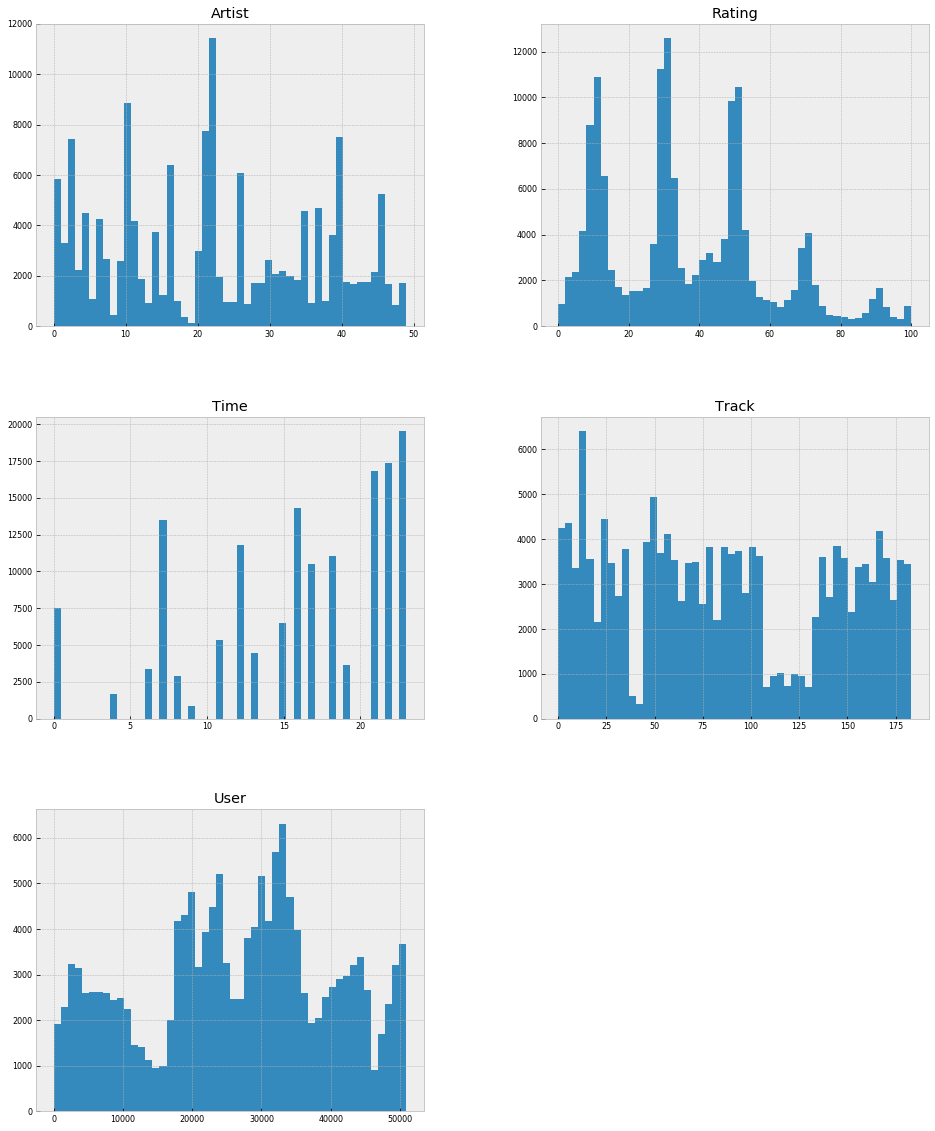

In [18]:
# Répartition des valeurs numériques - Train
train_num = train.select_dtypes(include = ['int64'])
train_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

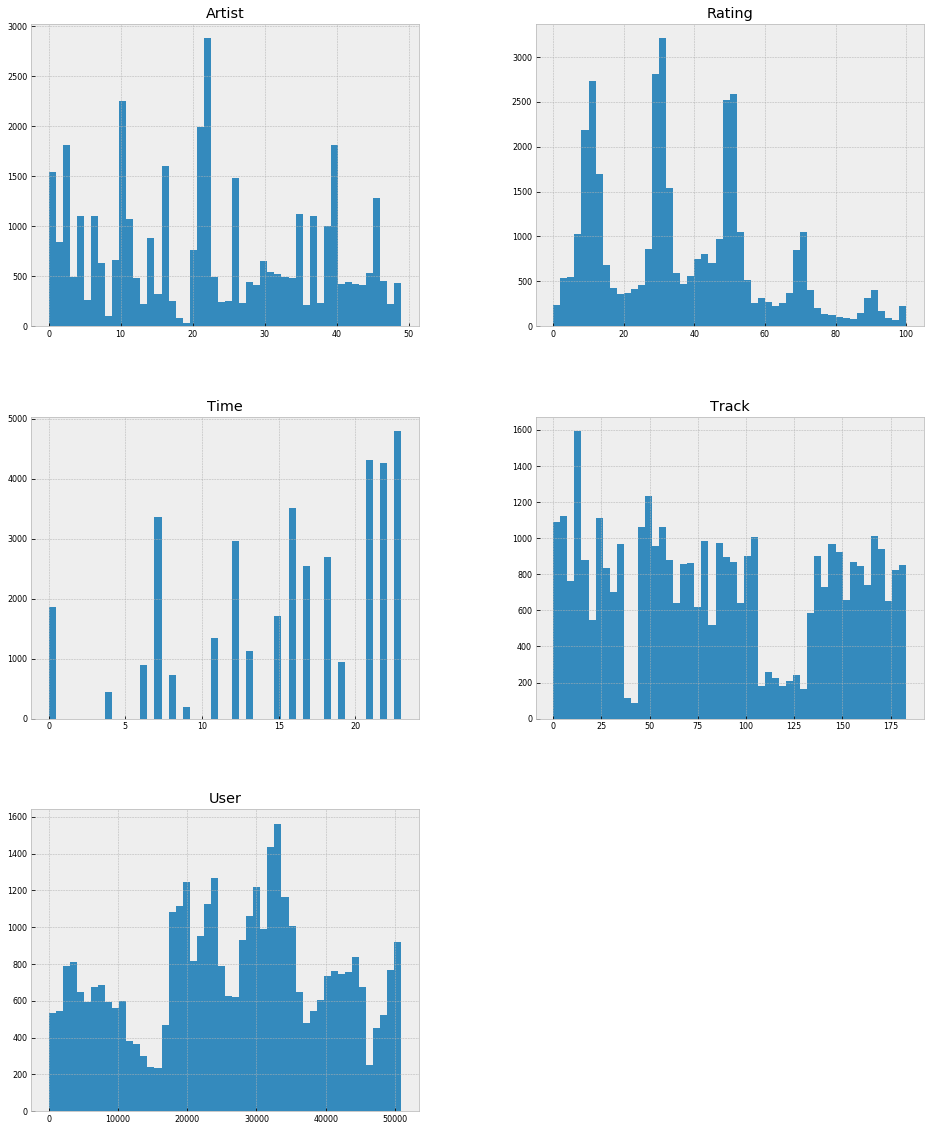

In [19]:
# Répartition des valeurs numériques - Test
test_num = test.select_dtypes(include = ['int64'])
test_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

## Analyse du csv users

Nous allons maintenant analyser les variables du jeu du csv 'users'. Nous affichons les informations globales et nous commençons par afficher la distribution des variables numériques.

Le fichier user.csv est plutôt bien renseigné, il existe cependant des variables ayant des valeurs nulles, nous devrons les retraiter plus tard. Les données sont de type int64, float64 et object. Les données de type object pourront être retaitées par la suite. Les données catégorielles devront être encodées suivant les inputs demandés par les différents modèles. 

In [20]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48645 entries, 0 to 48644
Data columns (total 27 columns):
RESPID       48645 non-null int64
GENDER       48645 non-null object
AGE          48178 non-null float64
WORKING      35520 non-null object
REGION       47605 non-null object
MUSIC        48645 non-null object
LIST_OWN     42706 non-null object
LIST_BACK    42820 non-null object
Q1           48645 non-null float64
Q2           48645 non-null float64
Q3           48645 non-null float64
Q4           48645 non-null float64
Q5           48645 non-null float64
Q6           48645 non-null float64
Q7           48645 non-null float64
Q8           48645 non-null float64
Q9           48645 non-null float64
Q10          48645 non-null float64
Q11          48645 non-null float64
Q12          48645 non-null float64
Q13          48645 non-null float64
Q14          48645 non-null float64
Q15          48645 non-null float64
Q16          42210 non-null float64
Q17          48645 non-null float64

In [21]:
users.describe()

,RESPID,AGE,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19
count,48645.000000,48178.000000,48645.000000,48645.000000,48645.000000,48645.000000,48645.000000,48645.000000,48645.000000,48645.000000,48645.000000,48645.000000,48645.000000,48645.000000,48645.000000,48645.000000,48645.000000,42210.000000,48645.000000,35520.000000,35520.000000
mean,25562.400391,39.277180,49.113570,54.624422,51.284449,37.309125,34.585430,39.333615,33.845330,29.161743,47.831737,55.011029,58.636433,53.665898,46.962657,53.446437,39.664562,35.579258,53.826288,42.232447,41.362631
std,15033.356108,15.955373,27.545252,23.770780,26.487641,23.598351,23.234577,25.744281,25.782182,24.267965,27.351142,25.486398,23.837543,25.389724,26.664165,25.795551,26.061055,25.374290,25.891354,25.680349,26.455730
min,0.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12161.000000,25.000000,28.000000,44.000000,31.000000,14.000000,12.000000,14.000000,10.000000,9.000000,28.000000,41.000000,48.000000,36.000000,28.000000,33.000000,13.000000,11.000000,35.000000,17.000000,14.000000
50%,26605.000000,39.000000,51.000000,53.000000,52.000000,34.000000,32.000000,35.000000,30.000000,23.000000,50.000000,53.000000,64.000000,54.000000,50.000000,53.000000,37.000000,32.000000,56.000000,47.000000,45.000000
75%,38766.000000,52.000000,70.000000,71.000000,71.000000,52.000000,51.000000,53.000000,52.000000,49.000000,70.000000,72.000000,73.000000,71.000000,68.000000,71.000000,56.000000,52.000000,71.000000,58.000000,57.000000
max,50927.000000,94.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


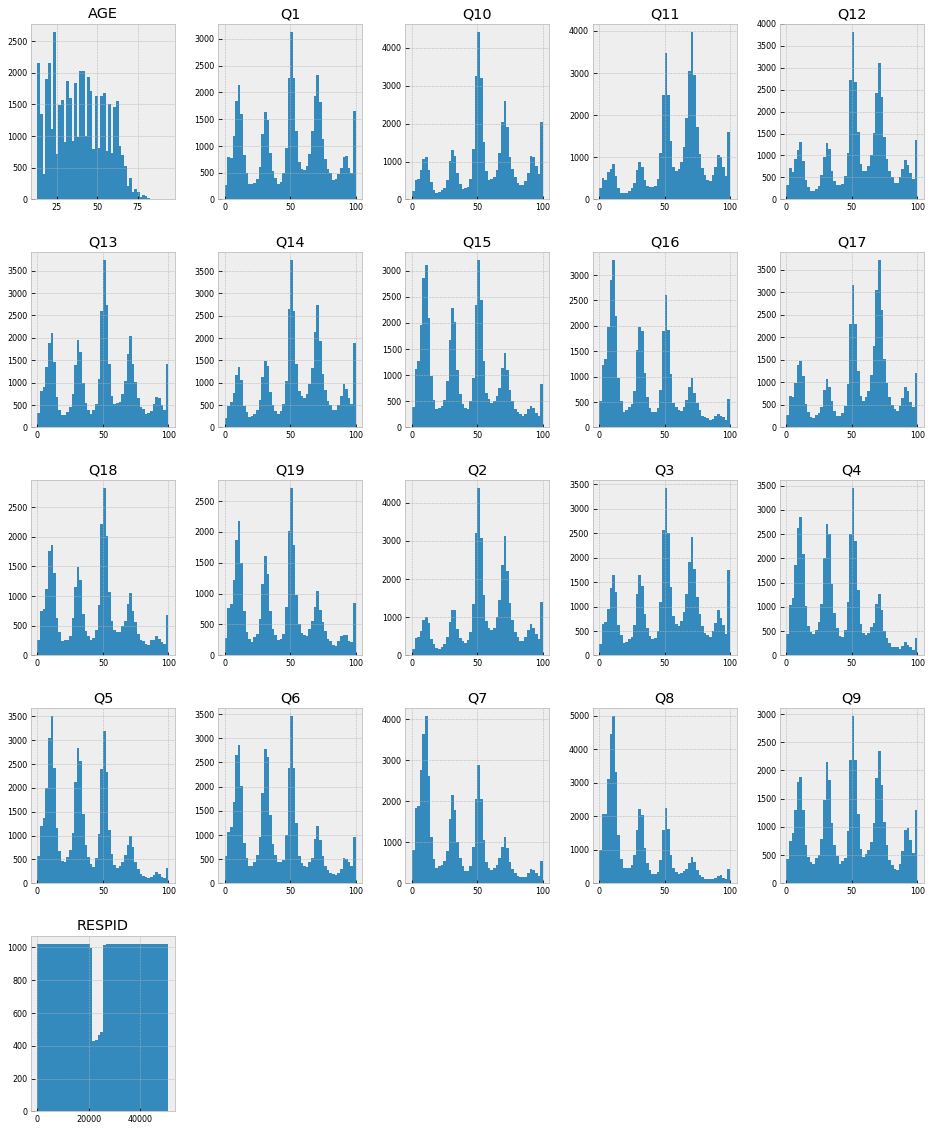

In [22]:
# Répartition des valeurs numériques - users
users_num = users.select_dtypes(include = ['int64', 'float64'])
users_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

Les réponses aux questions semblent respecter la même distribution. Lorsque l'on demande à un individu de noter quelque chose entre 0 et 100, les valeurs les plus choisies sont 10 - 25 - 50 - 75 et 90 (environ).

Nous faisons de même avec les autres variables : 

<Figure size 432x288 with 0 Axes>

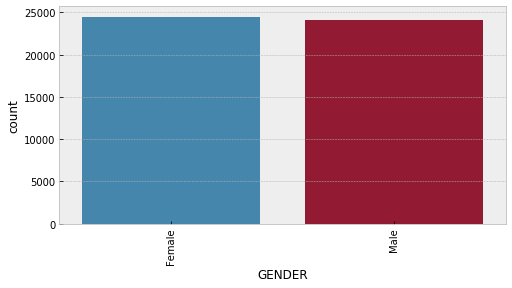

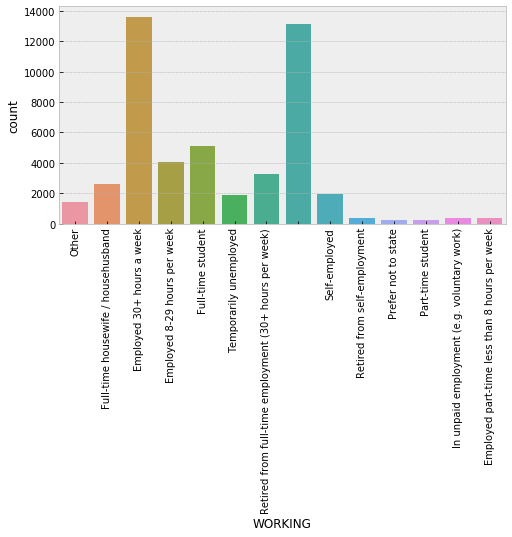

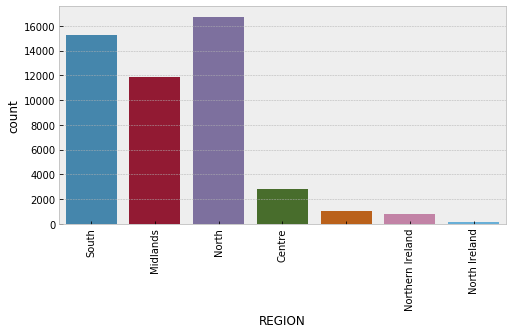

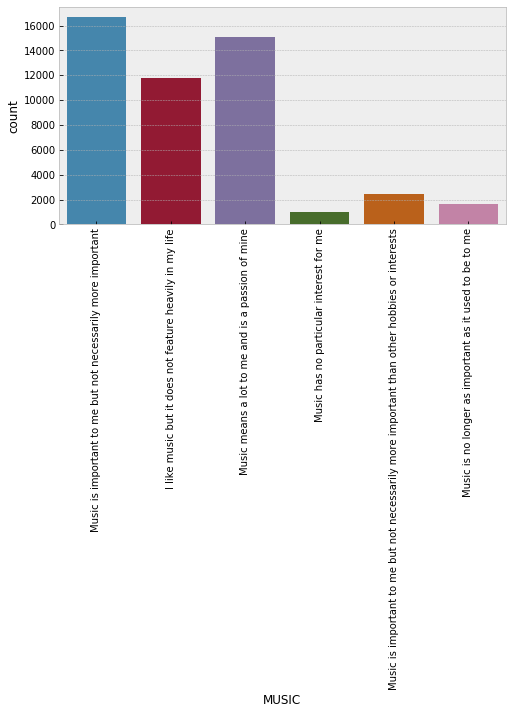

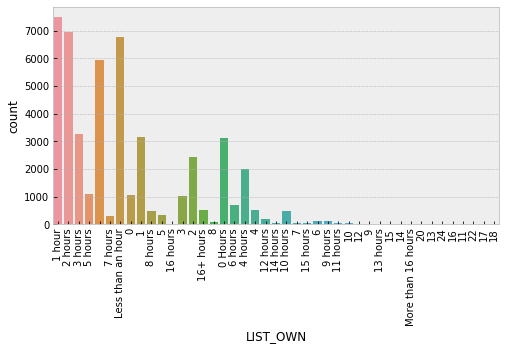

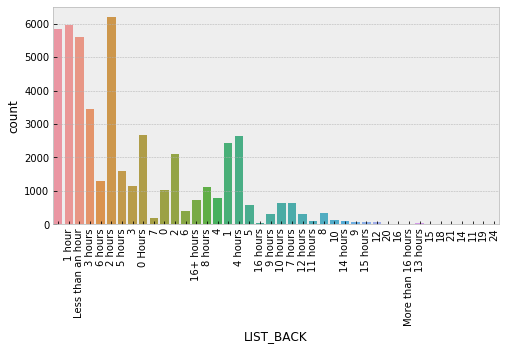

In [23]:
# Répartition des valeurs catégoriques et valeurs - users
#remplissage des valeurs vides par une chaîne vide pour l'affichage
users_cat = users.select_dtypes(['object']).fillna('')

for i, col in enumerate(users_cat.columns):
    plt.figure(i)
    plt.figure(figsize=(8, 4))
    g = sns.countplot(x=col, data=users_cat)
    g.set_xticklabels(g.get_xticklabels(), rotation=90)


Nous en déduisons que : 
 * Gender peut être considérée comme une variable booléenne
 * Working et Music possèdent des valeurs nulles
 * Region est une variable à six valeurs
 * List_own et list_black doivent être retraitées car elles comportent des valeurs en doublon et des valeurs nulles.


# Analyse du csv words

Le csv contient les identifiants des artistes et des répondants à l'enquête. Nous avons aussi deux catégories avec peu de valeurs et la plupart des champs sont des floats 64 correspondants au mot que le répondant à choisit pour qualifier la musique. Ces champs peuvent avoir la valeur 0 ou 1 et comportent beaucoup de valeurs nulles à retraiter, car un répondant ne qualifie pas la musique avec tous les mots. De plus la variable Unnamed: 87 ne comporte pas de valeurs et ne correspond pas à une information particulière.

In [24]:
words.describe()

,Artist,User,LIKE_ARTIST,Uninspired,Sophisticated,Aggressive,Edgy,Sociable,Laid back,Wholesome,Uplifting,Intriguing,Legendary,Free,Thoughtful,Outspoken,Serious,Good lyrics,Unattractive,Confident,Old,Youthful,Boring,Current,Colourful,Stylish,Cheap,Irrelevant,Heartfelt,Calm,Pioneer,Outgoing,Inspiring,Beautiful,Fun,Authentic,Credible,Way out,Cool,Catchy,Sensitive,Mainstream,Superficial,Annoying,Dark,Passionate,Not authentic,Good Lyrics,Background,Timeless,Depressing,Original,Talented,Worldly,Distinctive,Approachable,Genius,Trendsetter,Noisy,Upbeat,Relatable,Energetic,Exciting,Emotional,Nostalgic,None of these,Progressive,Sexy,Over,Rebellious,Fake,Cheesy,Popular,Superstar,Relaxed,Intrusive,Unoriginal,Dated,Iconic,Unapproachable,Classic,Playful,Arrogant,Warm,Soulful,Unnamed: 87
count,118301.000000,118301.000000,33308.000000,26154.000000,20724.000000,97577.000000,118301.000000,20724.000000,20724.000000,1040.000000,20724.000000,20724.000000,1040.000000,20724.000000,118301.000000,20724.000000,97577.000000,97577.000000,97577.000000,97577.000000,1040.000000,117261.000000,87080.000000,118301.000000,20724.000000,118301.000000,97577.00000,26154.000000,20724.000000,97577.000000,1040.000000,97577.000000,97577.000000,118301.000000,118301.000000,118301.000000,118301.000000,20724.000000,118301.000000,117261.000000,97577.000000,46254.000000,97577.000000,26154.000000,1040.000000,118301.000000,26154.000000,20724.000000,20724.000000,118301.000000,97577.000000,118301.000000,118301.000000,1040.000000,118301.000000,118301.000000,20724.000000,118301.000000,97577.000000,117261.000000,46254.000000,118301.000000,20724.000000,20724.000000,1040.000000,118301.000000,1040.000000,118301.000000,90157.000000,20724.000000,97577.000000,97577.000000,19684.000000,46254.000000,20724.000000,26154.000000,97577.000000,117261.000000,1040.000000,97577.000000,105235.000000,97577.000000,97577.000000,118301.000000,19684.000000,0.0
mean,22.471771,24637.126482,48.121591,0.088782,0.058724,0.053148,0.093304,0.068906,0.124107,0.036538,0.093080,0.065480,0.317308,0.204787,0.089813,0.043138,0.050022,0.150220,0.068295,0.150425,0.141346,0.101585,0.176309,0.153921,0.113829,0.092104,0.03798,0.046494,0.110403,0.150917,0.122115,0.048464,0.068612,0.106888,0.103025,0.120185,0.095840,0.024754,0.140996,0.206701,0.073726,0.064989,0.045134,0.168502,0.201923,0.078233,0.034488,0.179309,0.072187,0.086610,0.085573,0.144208,0.151875,0.088462,0.191638,0.088799,0.046806,0.040135,0.075776,0.106617,0.025511,0.134682,0.093032,0.125796,0.214423,0.088740,0.167308,0.038174,0.024247,0.068616,0.032313,0.058989,0.163026,0.016042,0.101525,0.021679,0.083616,0.067644,0.255769,0.019605,0.100423,0.058631,0.036525,0.092036,0.094595,NaN
std,14.717169,13831.302288,21.425649,0.284434,0.235113,0.224329,0.290860,0.253300,0.329712,0.187716,0.290552,0.247376,0.465652,0.403555,0.285915,0.203173,0.217992,0.357289,0.252252,0.357489,0.348546,0.302104,0.381085,0.360874,0.317612,0.289174,0.19115,0.210556,0.313399,0.357970,0.327577,0.214746,0.252795,0.308973,0.303993,0.325179,0.294373,0.155378,0.348019,0.404941,0.261326,0.246509,0.207598,0.374319,0.401628,0.268538,0.182483,0.383620,0.258803,0.281263,0.279735,0.351302,0.358901,0.284102,0.393592,0.284454,0.211227,0.196276,0.264641,0.308627,0.157674,0.341385,0.290485,0.331628,0.410619,0.284369,0.373430,0.191616,0.153815,0.252806,0.176831,0.235606,0.369399,0.125638,0.302030,0.145637,0.276813,0.251135,0.436503,0.138639,0.300564,0.234933,0.187593,0.289079,0.292662,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

In [25]:
words.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118301 entries, 0 to 118300
Data columns (total 88 columns):
Artist              118301 non-null int64
User                118301 non-null int64
HEARD_OF            118277 non-null object
OWN_ARTIST_MUSIC    33507 non-null object
LIKE_ARTIST         33308 non-null float64
Uninspired          26154 non-null float64
Sophisticated       20724 non-null float64
Aggressive          97577 non-null float64
Edgy                118301 non-null int64
Sociable            20724 non-null float64
Laid back           20724 non-null float64
Wholesome           1040 non-null float64
Uplifting           20724 non-null float64
Intriguing          20724 non-null float64
Legendary           1040 non-null float64
Free                20724 non-null float64
Thoughtful          118301 non-null int64
Outspoken           20724 non-null float64
Serious             97577 non-null float64
Good lyrics         97577 non-null float64
Unattractive        97577 non-null f

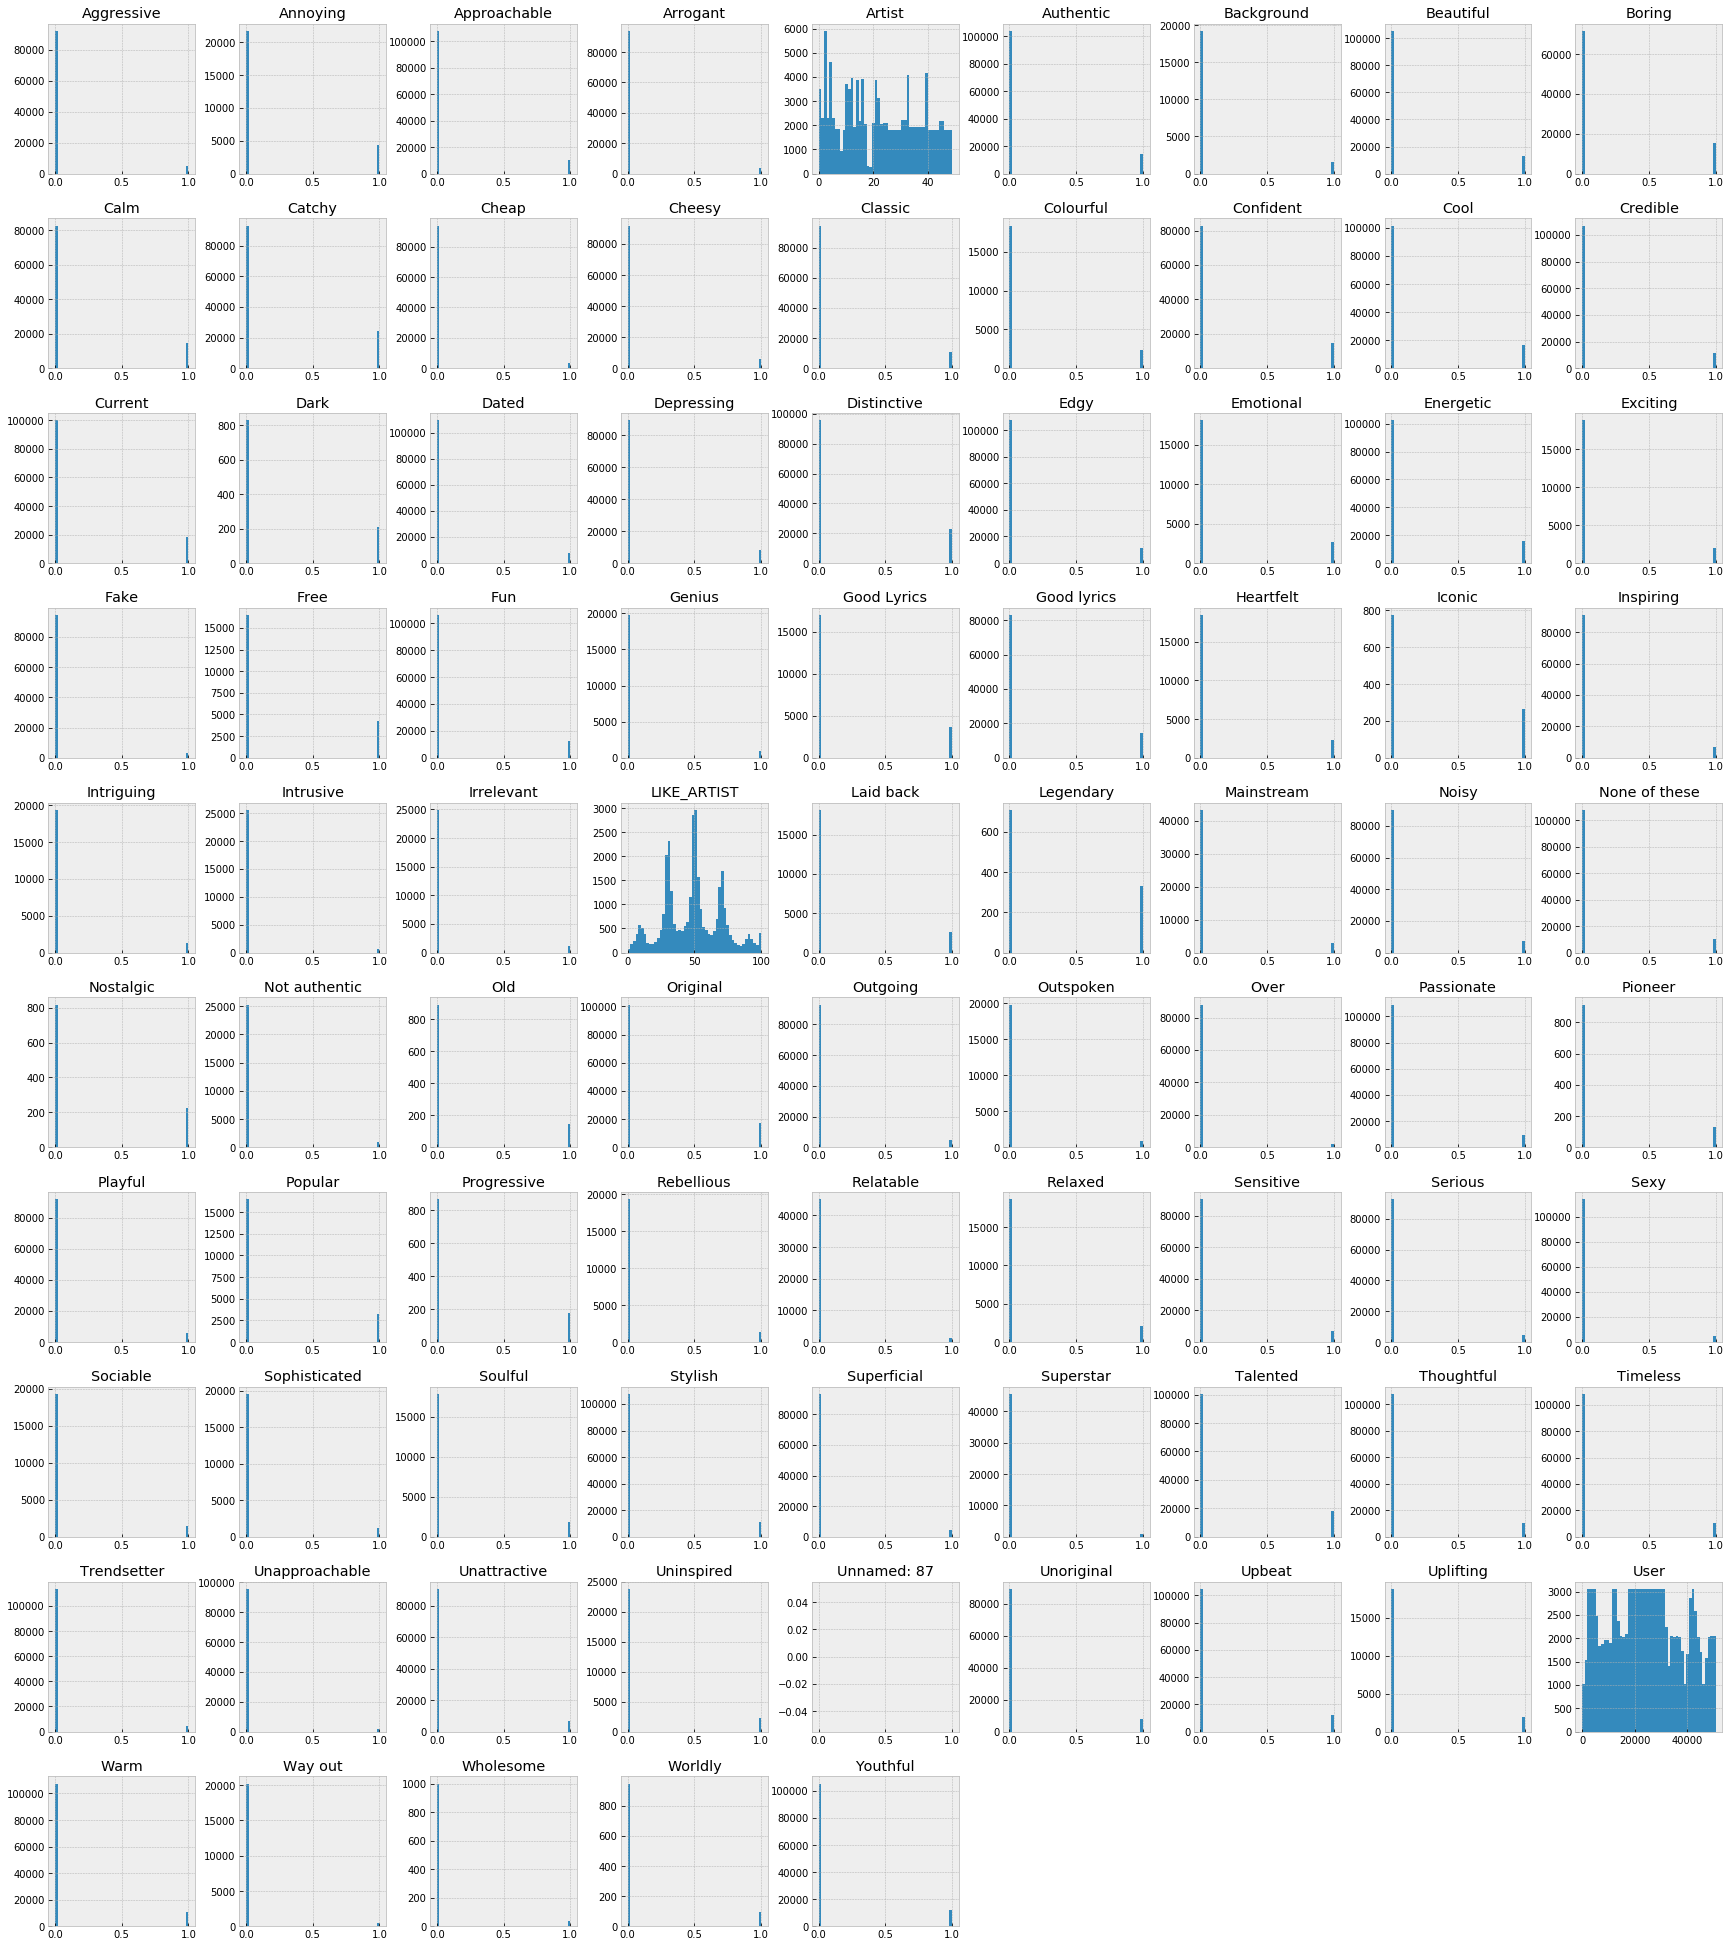

In [26]:
# Répartition des valeurs numériques - users
words_num = words.select_dtypes(include = ['int64', 'float64'])
words_num.hist(figsize=(30, 35), bins=50, xlabelsize=10, ylabelsize=10);

<Figure size 432x288 with 0 Axes>

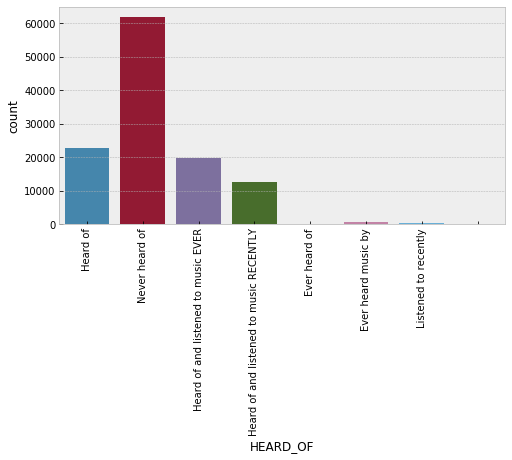

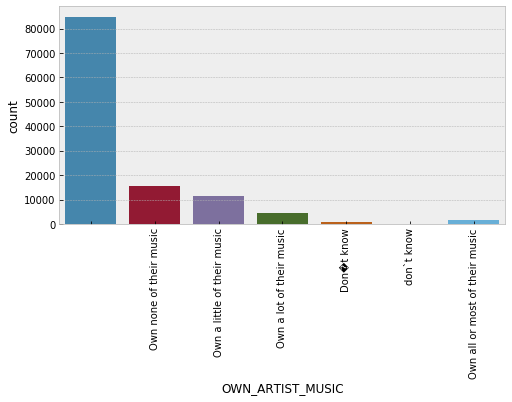

In [27]:
words_cat = words.select_dtypes(['object']).fillna('')


for i, col in enumerate(words_cat.columns):
    plt.figure(i)
    plt.figure(figsize=(8, 4))
    g = sns.countplot(x=col, data=words_cat)
    g.set_xticklabels(g.get_xticklabels(), rotation=90)

# Préprocessing

## suppression de la colonne Unnamed: 87

On choisit de supprimer la colonne Unnamed: 87 qui ne contient pas de valeurs

In [28]:
words = words.drop(['Unnamed: 87'], axis=1)

## fabrication du jeu d'entraînement

Il est maintenant nécessaire de regrouper les différents csv afin de constituer des jeux de données d'entraînements et de tests. Nous pouvons relever que la plupart des utilisateurs et des artistes sont déjà connus lors de la phase de test ce qui pourrait éventuellement amener a du data leakage et donc une diminution des performances sur des données totalement nouvelles.  La problématique ne pourra cependant pas être vérifiée dans le cadre du projet.

In [29]:
len(train)

150952

In [30]:
# left join entre train.csv et users.csv sur User = RESPID
train_merge_users = pd.merge(train, users, how='left', left_on=['User'], right_on=['RESPID'])
train_merge_users.head(5)

,Artist,Track,User,Time,Rating,RESPID,GENDER,AGE,WORKING,REGION,MUSIC,LIST_OWN,LIST_BACK,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19
0,33,85,34406,12,55,34406.0,Female,58.0,Employed 30+ hours a week,Midlands,Music is important to me but not necessarily more important,Less than an hour,1 hour,52.0,67.0,68.0,11.0,51.0,9.0,52.0,49.0,31.0,73.0,96.0,72.0,73.0,96.0,85.0,73.0,81.0,51.0,70.0
1,2,174,47314,17,29,47314.0,Male,80.0,Retired from full-time employment (30+ hours per week),South,I like music but it does not feature heavily in my life,NaN,NaN,53.0,28.0,25.0,48.0,69.0,50.0,33.0,34.0,35.0,58.0,34.0,35.0,48.0,49.0,8.0,28.0,29.0,50.0,32.0
2,40,177,50440,17,5,50440.0,Male,18.0,Employed 8-29 hours per week,South,Music means a lot to me and is a passion of mine,16+ hours,0 Hours,46.0,60.0,85.0,60.0,79.0,61.0,45.0,72.0,72.0,57.0,72.0,46.0,60.0,65.0,52.0,71.0,78.0,51.0,68.0
3,33,85,25762,11,9,25762.0,Female,20.0,Employed 30+ hours a week,Midlands,Music means a lot to me and is a passion of mine,Less than an hour,1 hour,54.0,54.0,52.0,53.0,53.0,54.0,54.0,54.0,53.0,52.0,53.0,56.0,57.0,56.0,56.0,56.0,56.0,56.0,57.0
4,21,48,22720,22,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
#Nous navons pas perdu d'enregistrements
len(train_merge_users)

150952

In [32]:
len(train_merge_users) - train_merge_users['RESPID'].count()

9519

L'étape précédente nous permet de relever que tous les utilisateurs du jeu d'entraînement ne sont pas présents dans le fichier users. Nous gardons pour l'instant les lignes vides mais nous pourrons jouer sur ce levier lors de la création des modèles.

In [33]:
train_merge_total = pd.merge(train_merge_users, words, how='left', left_on=['Artist', 'User'], right_on=['Artist', 'User'])
train_merge_total.head(5)

,Artist,Track,User,Time,Rating,RESPID,GENDER,AGE,WORKING,REGION,MUSIC,LIST_OWN,LIST_BACK,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,HEARD_OF,OWN_ARTIST_MUSIC,LIKE_ARTIST,Uninspired,Sophisticated,Aggressive,Edgy,Sociable,Laid back,Wholesome,Uplifting,Intriguing,Legendary,Free,Thoughtful,Outspoken,Serious,Good lyrics,Unattractive,Confident,Old,Youthful,Boring,Current,Colourful,Stylish,Cheap,Irrelevant,Heartfelt,Calm,Pioneer,Outgoing,Inspiring,Beautiful,Fun,Authentic,Credible,Way out,Cool,Catchy,Sensitive,Mainstream,Superficial,Annoying,Dark,Passionate,Not authentic,Good Lyrics,Background,Timeless,Depressing,Original,Talented,Worldly,Distinctive,Approachable,Genius,Trendsetter,Noisy,Upbeat,Relatable,Energetic,Exciting,Emotional,Nostalgic,None of these,Progressive,Sexy,Over,Rebellious,Fake,Cheesy,Popular,Superstar,Relaxed,Intrusive,Unoriginal,Dated,Iconic,Unapproachable,Classic,Playful,Arrogant,Warm,Soulful
0,33,85,34406,12,55,34406.0,Female,58.0,Employed 30+ hours a week,Midlands,Music is important to me but not necessarily more important,Less than an hour,1 hour,52.0,67.0,68.0,11.0,51.0,9.0,52.0,49.0,31.0,73.0,96.0,72.0,73.0,96.0,85.0,73.0,81.0,51.0,70.0,Heard of,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,1.0,0.0,0.0,NaN,0.0,0.0,1.0,NaN,1.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,1.0,0.0,NaN,1.0,1.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,1.0,0.0,NaN,0.0,0.0,1.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN
1,2,174,47314,17,29,47314.0,Male,80.0,Retired from full-time employment (30+ hours per week),South,I like music but it does not feature heavily in my life,NaN,NaN,53.0,28.0,25.0,48.0,69.0,50.0,33.0,34.0,35.0,58.0,34.0,35.0,48.0,49.0,8.0,28.0,29.0,50.0,32.0,Never heard of,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN
2,40,177,50440,17,5,50440.0,Male,18.0,Employed 8-29 hours per week,South,Music means a lot to me and is a passion of mine,16+ hours,0 Hours,46.0,60.0,85.0,60.0,79.0,61.0,45.0,72.0,72.0,57.0,72.0,46.0,60.0,65.0,52.0,71.0,78.0,51.0,68.0,Heard of,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,1.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,1.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,1.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,1.0,0.0,NaN,0.0,0.0,0.0,1.0,0.0,NaN
3,33,85,25762,11,9,25762.0,Female,20.0,Employed 30+ hours a week,Midlands,Music means a lot to me and is a passion of mine,Less than an hour,1 hour,54.0,54.0,52.0,53.0,53.0,54.0,54.0,54.0,53.0,52.0,53.0,56.0,57.0,56.0,56.0,56.0,56.0,56.0,57.0,Heard of,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN
4,21,48,22720,22,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Never heard of,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,1.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN


In [34]:
len(train_merge_total)

150952

## fabrication du jeu de test

In [35]:
len(test)

37738

In [36]:
# left join entre train.csv et users.csv sur User = RESPID
test_merge_users = pd.merge(test, users, how='left', left_on=['User'], right_on=['RESPID'])
test_merge_users.head(5)

,Artist,Track,User,Time,Rating,RESPID,GENDER,AGE,WORKING,REGION,MUSIC,LIST_OWN,LIST_BACK,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19
0,25,59,18161,21,49,18161.0,Male,44.0,Employed 8-29 hours per week,Midlands,I like music but it does not feature heavily in my life,Less than an hour,0 Hours,52.0,53.0,48.0,6.0,7.0,48.0,47.0,47.0,49.0,49.0,50.0,69.0,49.0,49.0,9.0,10.0,71.0,52.0,52.0
1,35,88,28759,23,46,28759.0,Male,36.0,Employed 30+ hours a week,South,Music is important to me but not necessarily more important than other hobbies or interests,2 hours,Less than an hour,52.0,51.0,67.0,52.0,34.0,53.0,32.0,32.0,53.0,72.0,68.0,68.0,69.0,70.0,70.0,NaN,71.0,52.0,47.0
2,21,48,20142,21,21,20142.0,Female,61.0,Retired from full-time employment (30+ hours per week),Midlands,I like music but it does not feature heavily in my life,0 Hours,1 hour,5.0,53.0,24.0,9.0,5.0,85.0,3.0,4.0,69.0,56.0,79.0,51.0,4.0,4.0,4.0,6.0,7.0,3.0,6.0
3,41,155,41201,16,42,41201.0,Female,14.0,Full-time student,South,Music is important to me but not necessarily more important,1 hour,2 hours,54.0,55.0,52.0,57.0,57.0,53.0,55.0,50.0,53.0,51.0,63.0,65.0,52.0,57.0,57.0,58.0,60.0,54.0,54.0
4,10,141,34253,12,11,34253.0,Female,63.0,Retired from full-time employment (30+ hours per week),Midlands,I like music but it does not feature heavily in my life,Less than an hour,2 hours,35.0,35.0,51.0,77.0,73.0,31.0,32.0,33.0,98.0,49.0,75.0,75.0,23.0,31.0,12.0,33.0,75.0,34.0,34.0


In [37]:
#Nous navons pas perdu d'enregistrements
len(test_merge_users)

37738

In [38]:
len(test_merge_users) - test_merge_users['RESPID'].count()

2338

La proportion d'utilisateurs non renseignés reste la même (environ) nous pouvons donc garder ces enregistrements dans le jeu d'entraînement

In [39]:
test_merge_total = pd.merge(test_merge_users, words, how='left', left_on=['Artist', 'User'], right_on=['Artist', 'User'])
test_merge_total.head(5)

,Artist,Track,User,Time,Rating,RESPID,GENDER,AGE,WORKING,REGION,MUSIC,LIST_OWN,LIST_BACK,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,HEARD_OF,OWN_ARTIST_MUSIC,LIKE_ARTIST,Uninspired,Sophisticated,Aggressive,Edgy,Sociable,Laid back,Wholesome,Uplifting,Intriguing,Legendary,Free,Thoughtful,Outspoken,Serious,Good lyrics,Unattractive,Confident,Old,Youthful,Boring,Current,Colourful,Stylish,Cheap,Irrelevant,Heartfelt,Calm,Pioneer,Outgoing,Inspiring,Beautiful,Fun,Authentic,Credible,Way out,Cool,Catchy,Sensitive,Mainstream,Superficial,Annoying,Dark,Passionate,Not authentic,Good Lyrics,Background,Timeless,Depressing,Original,Talented,Worldly,Distinctive,Approachable,Genius,Trendsetter,Noisy,Upbeat,Relatable,Energetic,Exciting,Emotional,Nostalgic,None of these,Progressive,Sexy,Over,Rebellious,Fake,Cheesy,Popular,Superstar,Relaxed,Intrusive,Unoriginal,Dated,Iconic,Unapproachable,Classic,Playful,Arrogant,Warm,Soulful
0,25,59,18161,21,49,18161.0,Male,44.0,Employed 8-29 hours per week,Midlands,I like music but it does not feature heavily in my life,Less than an hour,0 Hours,52.0,53.0,48.0,6.0,7.0,48.0,47.0,47.0,49.0,49.0,50.0,69.0,49.0,49.0,9.0,10.0,71.0,52.0,52.0,Never heard of,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,1.0,0.0,1.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,1.0,0.0,NaN,1.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN
1,35,88,28759,23,46,28759.0,Male,36.0,Employed 30+ hours a week,South,Music is important to me but not necessarily more important than other hobbies or interests,2 hours,Less than an hour,52.0,51.0,67.0,52.0,34.0,53.0,32.0,32.0,53.0,72.0,68.0,68.0,69.0,70.0,70.0,NaN,71.0,52.0,47.0,Never heard of,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,1.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,1.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN
2,21,48,20142,21,21,20142.0,Female,61.0,Retired from full-time employment (30+ hours per week),Midlands,I like music but it does not feature heavily in my life,0 Hours,1 hour,5.0,53.0,24.0,9.0,5.0,85.0,3.0,4.0,69.0,56.0,79.0,51.0,4.0,4.0,4.0,6.0,7.0,3.0,6.0,Never heard of,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,1.0,NaN,0.0,0.0,1.0,NaN,1.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,1.0,0.0,NaN,0.0,1.0,NaN,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN
3,41,155,41201,16,42,41201.0,Female,14.0,Full-time student,South,Music is important to me but not necessarily more important,1 hour,2 hours,54.0,55.0,52.0,57.0,57.0,53.0,55.0,50.0,53.0,51.0,63.0,65.0,52.0,57.0,57.0,58.0,60.0,54.0,54.0,Heard of,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,1.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,1.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN
4,10,141,34253,12,11,34253.0,Female,63.0,Retired from full-time employment (30+ hours per week),Midlands,I like music but it does not feature heavily in my life,Less than an hour,2 hours,35.0,35.0,51.0,77.0,73.0,31.0,32.0,33.0,98.0,49.0,75.0,75.0,23.0,31.0,12.0,33.0,75.0,34.0,34.0,Never heard of,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,1.0,0.0,NaN,0.0,1.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN


In [40]:
len(test_merge_total)

37738

# Feature engineering global

Une fois les datasets constitués, nous pouvons remplacer les valeurs nulles pas imputation.
Nous choississons empiriquement d'imputer la médiane lorsqu'une valeurs numérique n'est pas renseignée et une chaîne de caractère vide pour les données catégorielles.

## Elimination des doublons  LIST_OWN / LIST_BACK

In [41]:
def list_del_duplicates(df, col):
    return df[col].str.findall(r'\d+').map(lambda x: np.NaN if type(x) != list else 0 if type(x) == list and len(x) == 0 else x[0])

In [42]:
train_merge_total['LIST_OWN'] = list_del_duplicates(train_merge_total, 'LIST_OWN').astype('float64')
train_merge_total['LIST_BACK'] = list_del_duplicates(train_merge_total, 'LIST_BACK').astype('float64')

In [43]:
test_merge_total['LIST_OWN'] = list_del_duplicates(test_merge_total, 'LIST_OWN').astype('float64')
test_merge_total['LIST_BACK'] = list_del_duplicates(test_merge_total, 'LIST_BACK').astype('float64')

## suppression de la colonne RESPID en doublon avec user suite à la jointure

In [44]:
train_merge_total = train_merge_total.drop(['RESPID'], axis=1)

In [45]:
test_merge_total = test_merge_total.drop(['RESPID'], axis=1)

## Corrélation entre features

Nous analysons rapidement la corrélation entre les features. 
La cible (Rating) ne semble pas présenter de corrélation forte avec les autres features. Les features les plus corrélées sont les questions, car elles sont liées aux goût du répondants. Q1 et Q3 sont corrélées par exemple, nous pouvons en déduire qu'il est éventuellement cohérent de faire une ACP sur ces features afin de diminuer le nombre de variables ou faciliter l'apprentissage si besoin.

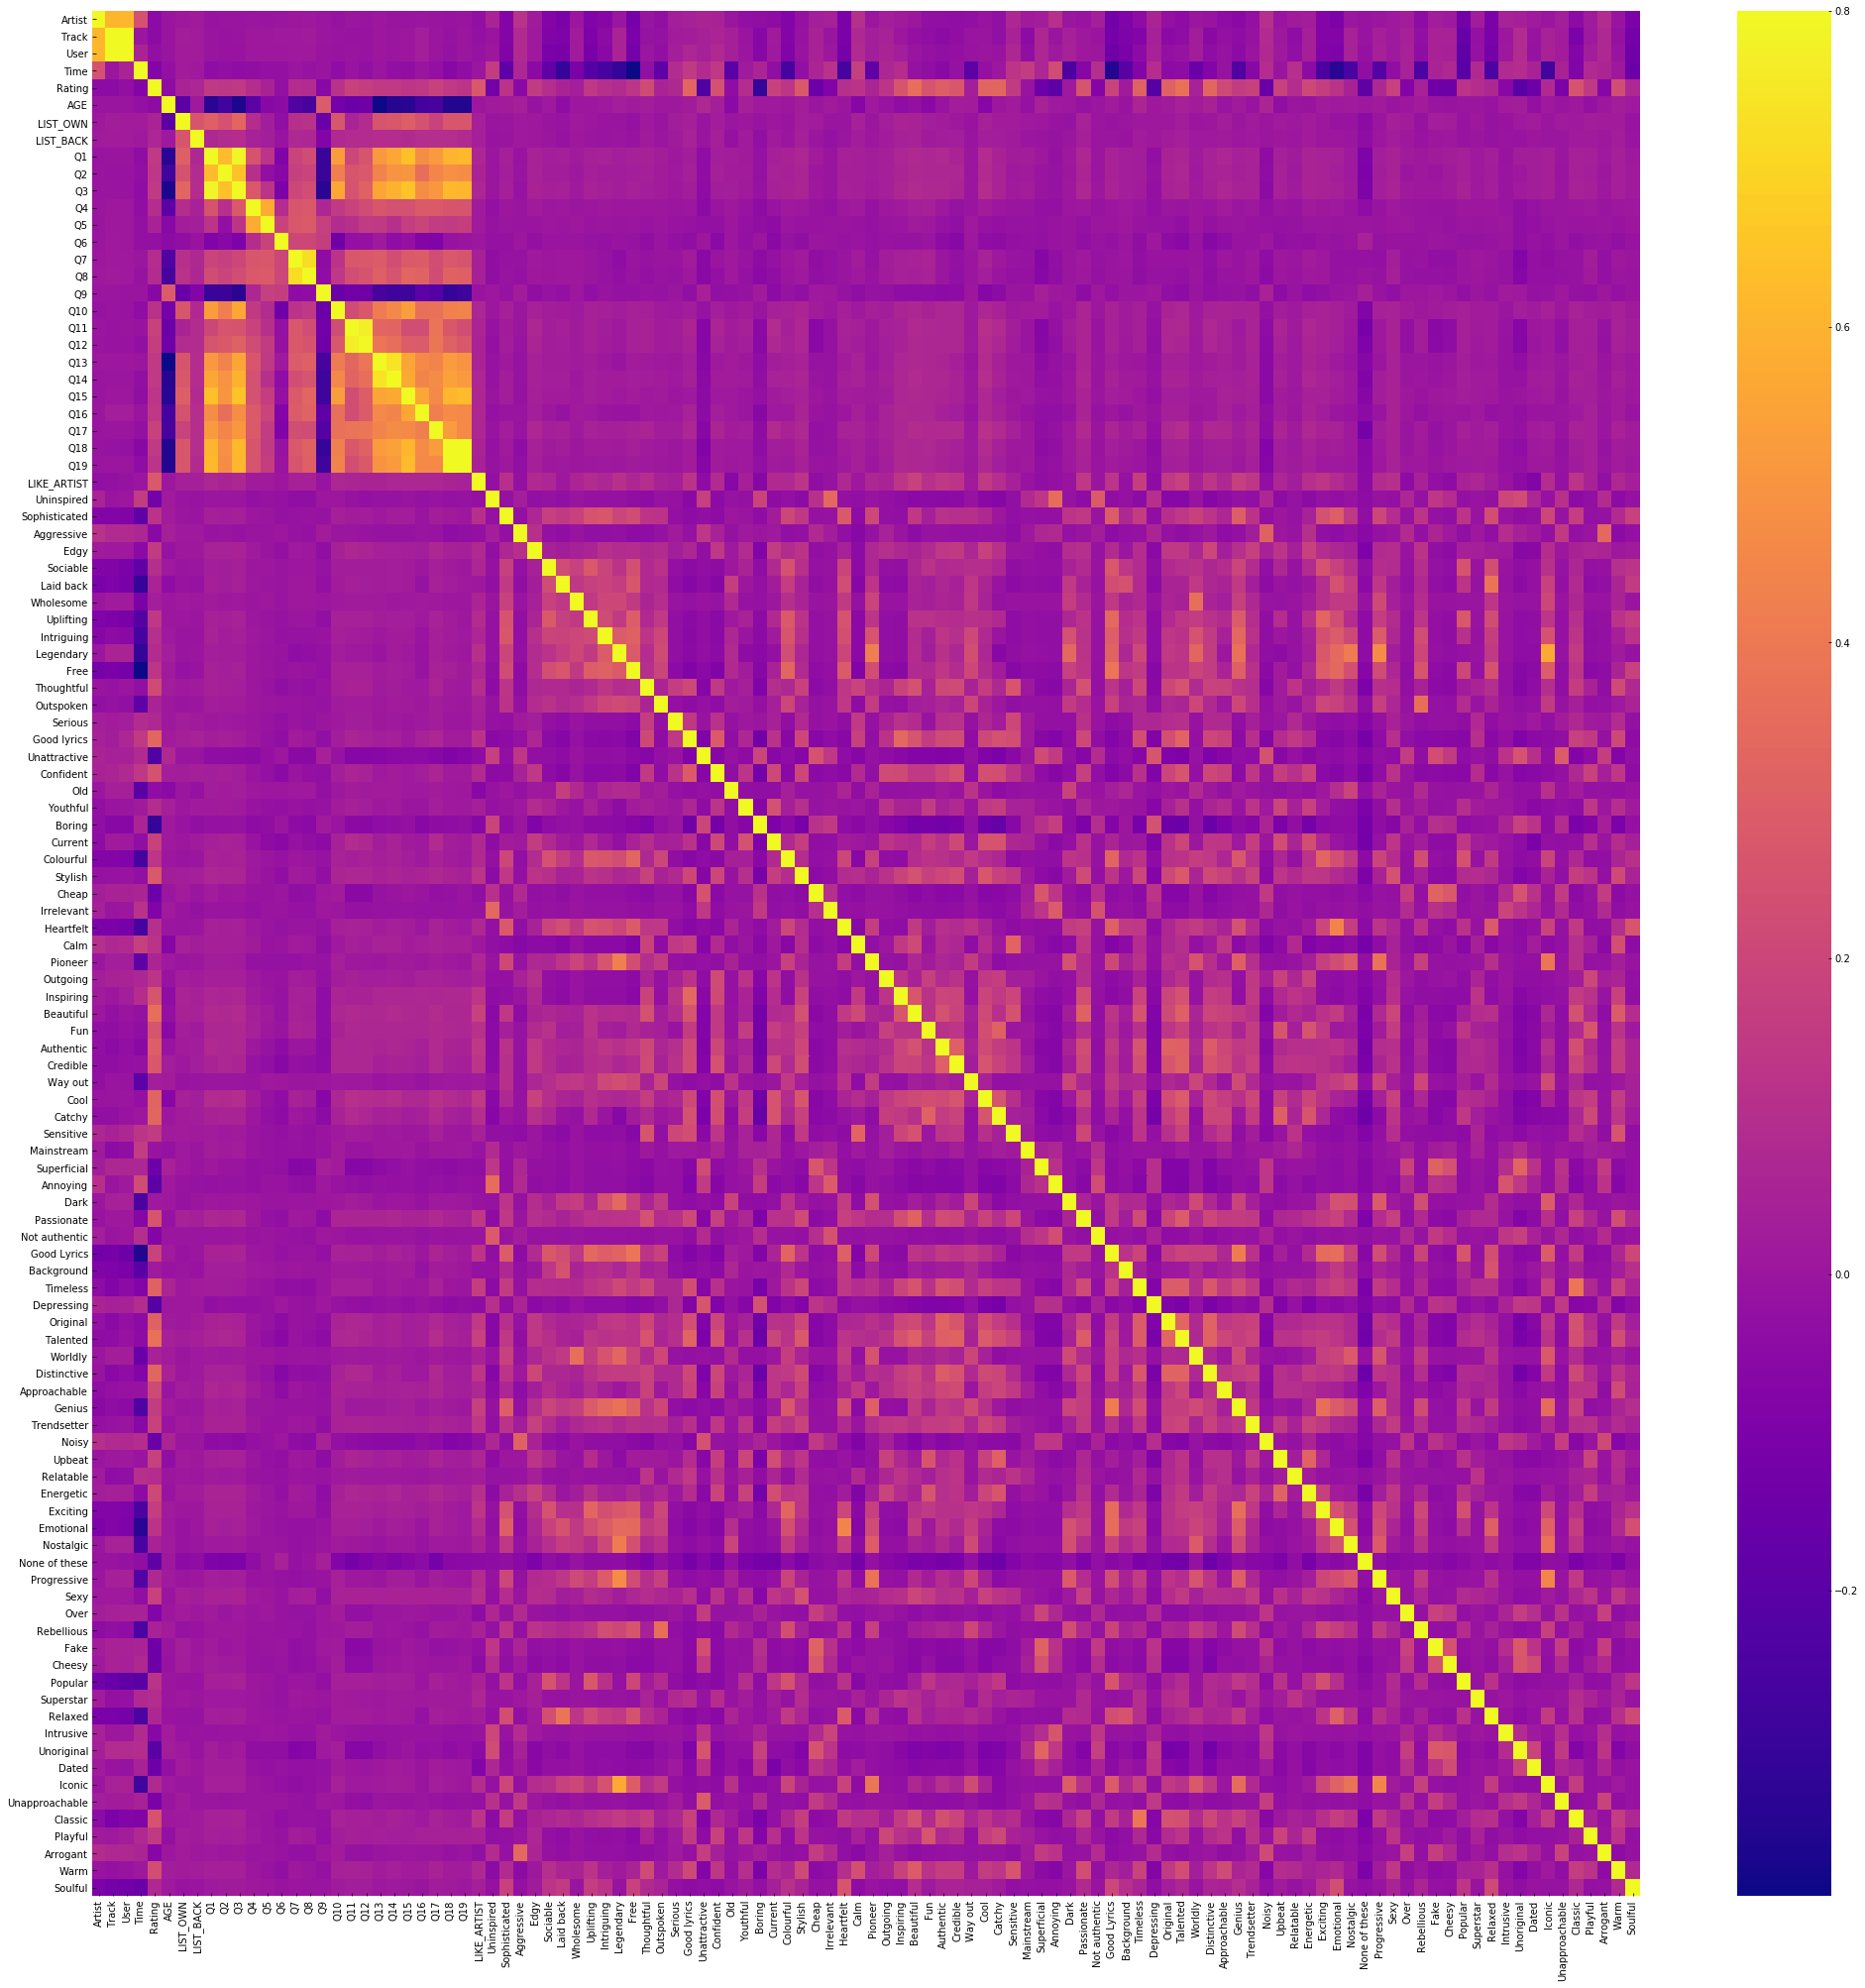

In [79]:
corr_matrix = train_merge_total.corr()
fig = plt.figure(figsize = (35,35))

sns.heatmap(corr_matrix, cmap = 'plasma', vmax=0.8, square = False)
plt.savefig("corrélation.png")

## Imputation des valeurs manquantes

Si nous avions imputé les valeurs avant l'opération de jointure, le dataset d'apprentissage contiendrait de l'information du dataset de test, ce qui conduit à un risque de data leakage. Nous préférons reproduire les traitements pour chacun des deux datasets afin de ne pas fausser les entraînements.

In [46]:
def feature_with_missing_values(df):
    temp = df.isnull().any()
    return list(temp[temp == True].index)

In [47]:
train_missing_values_features = feature_with_missing_values(train_merge_total)

In [48]:
test_missing_values_features = feature_with_missing_values(test_merge_total)

In [49]:
def treat_missing_values(df, missing_values_features):
    for feature in missing_values_features:
        if df[feature].dtype == np.float64 or df[feature].dtype == np.int64:
            mediane = df[feature].median()
            df[feature] = df[feature].fillna(mediane)
        else:
            df[feature] = df[feature].fillna('')
    return df

In [50]:
train_final = treat_missing_values(train_merge_total,train_missing_values_features)

In [51]:
test_final = treat_missing_values(test_merge_total,test_missing_values_features)

In [52]:
len(train_final)

150952

In [53]:
len(test_final)

37738

In [54]:
train_final.head(100)

,Artist,Track,User,Time,Rating,GENDER,AGE,WORKING,REGION,MUSIC,LIST_OWN,LIST_BACK,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,HEARD_OF,OWN_ARTIST_MUSIC,LIKE_ARTIST,Uninspired,Sophisticated,Aggressive,Edgy,Sociable,Laid back,Wholesome,Uplifting,Intriguing,Legendary,Free,Thoughtful,Outspoken,Serious,Good lyrics,Unattractive,Confident,Old,Youthful,Boring,Current,Colourful,Stylish,Cheap,Irrelevant,Heartfelt,Calm,Pioneer,Outgoing,Inspiring,Beautiful,Fun,Authentic,Credible,Way out,Cool,Catchy,Sensitive,Mainstream,Superficial,Annoying,Dark,Passionate,Not authentic,Good Lyrics,Background,Timeless,Depressing,Original,Talented,Worldly,Distinctive,Approachable,Genius,Trendsetter,Noisy,Upbeat,Relatable,Energetic,Exciting,Emotional,Nostalgic,None of these,Progressive,Sexy,Over,Rebellious,Fake,Cheesy,Popular,Superstar,Relaxed,Intrusive,Unoriginal,Dated,Iconic,Unapproachable,Classic,Playful,Arrogant,Warm,Soulful
0,33,85,34406,12,55,Female,58.0,Employed 30+ hours a week,Midlands,Music is important to me but not necessarily more important,0.0,1.0,52.0,67.0,68.0,11.0,51.0,9.0,52.0,49.0,31.0,73.0,96.0,72.0,73.0,96.0,85.0,73.0,81.0,51.0,70.0,Heard of,,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,174,47314,17,29,Male,80.0,Retired from full-time employment (30+ hours per week),South,I like music but it does not feature heavily in my life,1.0,2.0,53.0,28.0,25.0,48.0,69.0,50.0,33.0,34.0,35.0,58.0,34.0,35.0,48.0,49.0,8.0,28.0,29.0,50.0,32.0,Never heard of,,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,40,177,50440,17,5,Male,18.0,Employed 8-29 hours per week,South,Music means a lot to me and is a passion of mine,16.0,0.0,46.0,60.0,85.0,60.0,79.0,61.0,45.0,72.0,72.0,57.0,72.0,46.0,60.0,65.0,52.0,71.0,78.0,51.0,68.0,Heard of,,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,33,85,25762,11,9,Female,20.0,Employed 30+ hours a week,Midlands,Music means a lot to me and is a passion of mine,0.0,1.0,54.0,54.0,52.0,53.0,53.0,54.0,54.0,54.0,53.0,52.0,53.0,56.0,57.0,56.0,56.0,56.0,56.0,56.0,57.0,Heard of,,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,21,48,22720,22,8,,39.0,,,,1.0,2.0,51.0,53.0,52.0,34.0,32.0,35.0,30.0,23.0,50.0,53.0,64.0,53.0,50.0,53.0,36.0,32.0,56.0,47.0,44.0,Never heard of,,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,13,31,11172,19,32,Female,20.0,Full-time student,Midlands,Music means a lot to me and is a passion of mine,3.0,1.0,50.0,51.0,51.0,51.0,51.0,51.0,7.0,11.0,52.0,92.0,55.0,55.0,32.0,34.0,9.0,49.0,50.0,51.0,50.0,Heard of,,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [55]:
test_final.head(100)

,Artist,Track,User,Time,Rating,GENDER,AGE,WORKING,REGION,MUSIC,LIST_OWN,LIST_BACK,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,HEARD_OF,OWN_ARTIST_MUSIC,LIKE_ARTIST,Uninspired,Sophisticated,Aggressive,Edgy,Sociable,Laid back,Wholesome,Uplifting,Intriguing,Legendary,Free,Thoughtful,Outspoken,Serious,Good lyrics,Unattractive,Confident,Old,Youthful,Boring,Current,Colourful,Stylish,Cheap,Irrelevant,Heartfelt,Calm,Pioneer,Outgoing,Inspiring,Beautiful,Fun,Authentic,Credible,Way out,Cool,Catchy,Sensitive,Mainstream,Superficial,Annoying,Dark,Passionate,Not authentic,Good Lyrics,Background,Timeless,Depressing,Original,Talented,Worldly,Distinctive,Approachable,Genius,Trendsetter,Noisy,Upbeat,Relatable,Energetic,Exciting,Emotional,Nostalgic,None of these,Progressive,Sexy,Over,Rebellious,Fake,Cheesy,Popular,Superstar,Relaxed,Intrusive,Unoriginal,Dated,Iconic,Unapproachable,Classic,Playful,Arrogant,Warm,Soulful
0,25,59,18161,21,49,Male,44.0,Employed 8-29 hours per week,Midlands,I like music but it does not feature heavily in my life,0.0,0.0,52.0,53.0,48.0,6.0,7.0,48.0,47.0,47.0,49.0,49.0,50.0,69.0,49.0,49.0,9.0,10.0,71.0,52.0,52.0,Never heard of,,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,35,88,28759,23,46,Male,36.0,Employed 30+ hours a week,South,Music is important to me but not necessarily more important than other hobbies or interests,2.0,0.0,52.0,51.0,67.0,52.0,34.0,53.0,32.0,32.0,53.0,72.0,68.0,68.0,69.0,70.0,70.0,32.0,71.0,52.0,47.0,Never heard of,,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,21,48,20142,21,21,Female,61.0,Retired from full-time employment (30+ hours per week),Midlands,I like music but it does not feature heavily in my life,0.0,1.0,5.0,53.0,24.0,9.0,5.0,85.0,3.0,4.0,69.0,56.0,79.0,51.0,4.0,4.0,4.0,6.0,7.0,3.0,6.0,Never heard of,,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,41,155,41201,16,42,Female,14.0,Full-time student,South,Music is important to me but not necessarily more important,1.0,2.0,54.0,55.0,52.0,57.0,57.0,53.0,55.0,50.0,53.0,51.0,63.0,65.0,52.0,57.0,57.0,58.0,60.0,54.0,54.0,Heard of,,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10,141,34253,12,11,Female,63.0,Retired from full-time employment (30+ hours per week),Midlands,I like music but it does not feature heavily in my life,0.0,2.0,35.0,35.0,51.0,77.0,73.0,31.0,32.0,33.0,98.0,49.0,75.0,75.0,23.0,31.0,12.0,33.0,75.0,34.0,34.0,Never heard of,,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,43,159,42337,16,51,Female,50.0,Temporarily unemployed,Midlands,I like music but it does not feature heavily in my life,0.0,0.

On regarde s'il reste des valeurs non remplies

In [56]:
train_final.isna().sum().sum()

0

In [57]:
test_final.isna().sum().sum()

0

# Export du dataset

Nous choisissons le format feather qui est plus adapté que le csv pour les fichiers volumineux. Une fois exporté, le dataset pourra être utilisé pour alimenter les différents tpes de modèles, il faudra cepedant appliquer des opérations de features engineering spécifiques à ces modèles (encodage des catégories, standardisation...)

In [58]:
import feather
# pip install feather-format 
path_train = './input/train_final.feather'
path_test = './input/test_final.feather'
 
feather.write_dataframe(train_final, path_train)
feather.write_dataframe(test_final, path_test)

# Test Import

In [59]:
df_train = feather.read_dataframe(path_train)
df_train.head(50)

,Artist,Track,User,Time,Rating,GENDER,AGE,WORKING,REGION,MUSIC,LIST_OWN,LIST_BACK,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,HEARD_OF,OWN_ARTIST_MUSIC,LIKE_ARTIST,Uninspired,Sophisticated,Aggressive,Edgy,Sociable,Laid back,Wholesome,Uplifting,Intriguing,Legendary,Free,Thoughtful,Outspoken,Serious,Good lyrics,Unattractive,Confident,Old,Youthful,Boring,Current,Colourful,Stylish,Cheap,Irrelevant,Heartfelt,Calm,Pioneer,Outgoing,Inspiring,Beautiful,Fun,Authentic,Credible,Way out,Cool,Catchy,Sensitive,Mainstream,Superficial,Annoying,Dark,Passionate,Not authentic,Good Lyrics,Background,Timeless,Depressing,Original,Talented,Worldly,Distinctive,Approachable,Genius,Trendsetter,Noisy,Upbeat,Relatable,Energetic,Exciting,Emotional,Nostalgic,None of these,Progressive,Sexy,Over,Rebellious,Fake,Cheesy,Popular,Superstar,Relaxed,Intrusive,Unoriginal,Dated,Iconic,Unapproachable,Classic,Playful,Arrogant,Warm,Soulful
0,33,85,34406,12,55,Female,58.0,Employed 30+ hours a week,Midlands,Music is important to me but not necessarily more important,0.0,1.0,52.0,67.0,68.0,11.0,51.0,9.0,52.0,49.0,31.0,73.0,96.0,72.0,73.0,96.0,85.0,73.0,81.0,51.0,70.0,Heard of,,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,174,47314,17,29,Male,80.0,Retired from full-time employment (30+ hours per week),South,I like music but it does not feature heavily in my life,1.0,2.0,53.0,28.0,25.0,48.0,69.0,50.0,33.0,34.0,35.0,58.0,34.0,35.0,48.0,49.0,8.0,28.0,29.0,50.0,32.0,Never heard of,,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,40,177,50440,17,5,Male,18.0,Employed 8-29 hours per week,South,Music means a lot to me and is a passion of mine,16.0,0.0,46.0,60.0,85.0,60.0,79.0,61.0,45.0,72.0,72.0,57.0,72.0,46.0,60.0,65.0,52.0,71.0,78.0,51.0,68.0,Heard of,,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,33,85,25762,11,9,Female,20.0,Employed 30+ hours a week,Midlands,Music means a lot to me and is a passion of mine,0.0,1.0,54.0,54.0,52.0,53.0,53.0,54.0,54.0,54.0,53.0,52.0,53.0,56.0,57.0,56.0,56.0,56.0,56.0,56.0,57.0,Heard of,,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,21,48,22720,22,8,,39.0,,,,1.0,2.0,51.0,53.0,52.0,34.0,32.0,35.0,30.0,23.0,50.0,53.0,64.0,53.0,50.0,53.0,36.0,32.0,56.0,47.0,44.0,Never heard of,,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,13,31,11172,19,32,Female,20.0,Full-time student,Midlands,Music means a lot to me and is a passion of mine,3.0,1.0,50.0,51.0,51.0,51.0,51.0,51.0,7.0,11.0,52.0,92.0,55.0,55.0,32.0,34.0,9.0,49.0,50.0,51.0,50.0,Heard of,,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [60]:
df_test = feather.read_dataframe(path_test)
df_test.head(50)

,Artist,Track,User,Time,Rating,GENDER,AGE,WORKING,REGION,MUSIC,LIST_OWN,LIST_BACK,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Q16,Q17,Q18,Q19,HEARD_OF,OWN_ARTIST_MUSIC,LIKE_ARTIST,Uninspired,Sophisticated,Aggressive,Edgy,Sociable,Laid back,Wholesome,Uplifting,Intriguing,Legendary,Free,Thoughtful,Outspoken,Serious,Good lyrics,Unattractive,Confident,Old,Youthful,Boring,Current,Colourful,Stylish,Cheap,Irrelevant,Heartfelt,Calm,Pioneer,Outgoing,Inspiring,Beautiful,Fun,Authentic,Credible,Way out,Cool,Catchy,Sensitive,Mainstream,Superficial,Annoying,Dark,Passionate,Not authentic,Good Lyrics,Background,Timeless,Depressing,Original,Talented,Worldly,Distinctive,Approachable,Genius,Trendsetter,Noisy,Upbeat,Relatable,Energetic,Exciting,Emotional,Nostalgic,None of these,Progressive,Sexy,Over,Rebellious,Fake,Cheesy,Popular,Superstar,Relaxed,Intrusive,Unoriginal,Dated,Iconic,Unapproachable,Classic,Playful,Arrogant,Warm,Soulful
0,25,59,18161,21,49,Male,44.0,Employed 8-29 hours per week,Midlands,I like music but it does not feature heavily in my life,0.0,0.0,52.0,53.0,48.0,6.0,7.0,48.0,47.0,47.0,49.0,49.0,50.0,69.0,49.0,49.0,9.0,10.0,71.0,52.0,52.0,Never heard of,,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,35,88,28759,23,46,Male,36.0,Employed 30+ hours a week,South,Music is important to me but not necessarily more important than other hobbies or interests,2.0,0.0,52.0,51.0,67.0,52.0,34.0,53.0,32.0,32.0,53.0,72.0,68.0,68.0,69.0,70.0,70.0,32.0,71.0,52.0,47.0,Never heard of,,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,21,48,20142,21,21,Female,61.0,Retired from full-time employment (30+ hours per week),Midlands,I like music but it does not feature heavily in my life,0.0,1.0,5.0,53.0,24.0,9.0,5.0,85.0,3.0,4.0,69.0,56.0,79.0,51.0,4.0,4.0,4.0,6.0,7.0,3.0,6.0,Never heard of,,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,41,155,41201,16,42,Female,14.0,Full-time student,South,Music is important to me but not necessarily more important,1.0,2.0,54.0,55.0,52.0,57.0,57.0,53.0,55.0,50.0,53.0,51.0,63.0,65.0,52.0,57.0,57.0,58.0,60.0,54.0,54.0,Heard of,,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10,141,34253,12,11,Female,63.0,Retired from full-time employment (30+ hours per week),Midlands,I like music but it does not feature heavily in my life,0.0,2.0,35.0,35.0,51.0,77.0,73.0,31.0,32.0,33.0,98.0,49.0,75.0,75.0,23.0,31.0,12.0,33.0,75.0,34.0,34.0,Never heard of,,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,43,159,42337,16,51,Female,50.0,Temporarily unemployed,Midlands,I like music but it does not feature heavily in my life,0.0,0.